# EDA (downloaded document corpus) for 'debiaser' data product
#### Sagar Setru, September 21th, 2020

## Brief description using CoNVO framework

### Context

Some people are eager to get news from outside of their echo chamber. However, they do not know where to go outside of their echo chambers, and may also have some activation energy when it comes to seeking information from other sources. In the meantime, most newsfeeds only push you content that you agree with. You end up in an echo chamber, but may not have ever wanted to be in one in the first place.

### Need

A way to find news articles from different yet reliable media sources.

### Vision

Debiaser, a data product (maybe Chrome plug-in?) that will recommend news articles similar in topic to the one currently being read, but from several pre-curated and reliable news media organizations across the political spectrum, for example, following the "media bias chart" here https://www.adfontesmedia.com/ or the "media bias ratings" here: https://www.allsides.com/media-bias/media-bias-ratings. The app will determine the main topics of the text of a news article, and then show links to similar articles from other news organizations.

The product will generate topics for a given document via latent Dirichlet allocation (LDA) and then search news websites for the topic words generated.

Caveats: Many of these articles may be behind paywalls. News aggregators already basically do this. How different is this than just searching Google using the title of an article?

### Outcome

People who are motivated to engage in content outside of their echo chambers have a tool that enables them to quickly find news similar to what they are currently reading, but from a variety of news organizations.

### testing single document lda on these articles

In [2]:
# make sure I'm in the right environment (should be 'debiaser')
import os
print('Conda environment:')
print(os.environ['CONDA_DEFAULT_ENV'])

Conda environment:
debiaser


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import json

# NLP Packages
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# to break articles up into sentences
from nltk import tokenize

import pyLDAvis
import pyLDAvis.gensim

from text_processing_functions import process_all_articles
from text_processing_functions import remove_stopwords
from text_processing_functions import get_simple_corpus_dictionary_bow
from text_processing_functions import entity_recognizer
from text_processing_functions import get_topic_words_mean_std_prob_frequency
from text_processing_functions import sort_topics_mean_frequency
print('DONE')

DONE


In [7]:
all_news_df = pd.read_csv('./all_the_news/all_news_df_processed.csv')
all_news_df.head()

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,index,index.1,id,title,author,date,content,year,month,publication,category,digital,section,url,article_length
0,0,0,1,Agent Cooper in Twin Peaks is the audience: on...,\nTasha Robinson\n,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,2121
1,1,1,2,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,1948
2,2,2,3,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,3011
3,3,3,4,How Anker is beating Apple and Samsung at thei...,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,3281
4,4,4,5,Tour Black Panther’s reimagined homeland with ...,\nKwame Opam\n,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,Longform,1.0,NaN,NaN,239


In [8]:
def load_stop_words_csv_to_list(full_file_name):
    """fxn that loads stop words list downloaded from git repo called 'news-stopwords'"""
    
    stop_words = pd.read_csv(full_file_name)

    stop_words = stop_words['term']

    stop_words = [word for word in stop_words]
    
    return stop_words

In [172]:
def count_word_frequencies(article_processed_whole,n_topic_words):
    """
    fxn that does simple counting of word frequency.
    Goal is to have some baseline for how single doc LDA approach 
    compares to just counting most common words.
    """
    
    # dictionary of word counts
    word_dict_count = {}

    for word in article_processed_whole[0]:

        if word in word_dict_count.keys():

            word_dict_count[word] += 1

        else:

            word_dict_count[word] = 1

    # make list for word counts
    word_counts = []

    # loop through dictionary
    for key, value in word_dict_count.items():
        word_counts.append(value)
    
    # get unique values of word counts
    word_counts = list(set(word_counts))

    # sort counts from high to low 
    word_counts = sorted(word_counts, reverse=True)

    # keep top 5 word counts
    word_counts_top = word_counts[0:n_topic_words]

    # list for most common words
    most_common_words_list = []
    most_common_words_string = ''

    # loop through dictionary
    for key, value in word_dict_count.items():

        # if value of this word is one of the top ones, add this word for list of common words
        if value in word_counts_top:
            most_common_words_list.append(key)
            most_common_words_string += ' '+key
            
    return word_dict_count, word_counts_top, most_common_words_list, most_common_words_string

In [188]:
def get_jaccard_sim(list1, list2): 
    """
    fxn calculates jaccard sim between two lists of words
    from https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50
    """
    a = set(list1) 
    b = set(list2)
    
    c = a.intersection(b)
    
    return float(len(c)) / (len(a) + len(b) - len(c))

In [9]:
# choose list of stop words

# choose whether 1k, 10k, 100k, or nltk
which_stop_words = '1k'
# which_stop_words = '10k'
# which_stop_words = '100k'
# which_stop_words = 'nltk'

stop_words_path = '/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/stop_words_db/news-stopwords-master/'


if which_stop_words == '1k':
    
    # doing 1k words list
    stop_words_file_name = 'sw1k.csv'
    
    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)
    
elif which_stop_words == '10k':
    
    # doing 10k words list
    stop_words_file_name = 'sw10k.csv'

    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)

elif which_stop_words == '100k':
    
    # doing 100k
    stop_words_file_name = 'sw100k.csv'  
    
    # get full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)


elif which_stop_words == 'nltk':
    # import from nltk
    from nltk.corpus import stopwords
    
    stop_words = stopwords.words('english')
    
else:
    print('Select proper variable name for "which_stop_words"')
    
# adding custom words
stop_words.append('said')
stop_words.append('youre')

In [91]:
# get a random sampling of these articles for testing single document lda

# number of times to draw a bootstrap sampling
n_bootstrap_samples = 1

# number of articles to draw per sampling
n_articles_per_sample = 1


In [114]:
test = np.zeros((3,3,3))
test[:] = np.nan
print(test)

[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]


[[0.04653713]
 [0.01589087]
 [0.01021555]
 [0.01021546]
 [0.00908053]
 [0.00794538]
 [0.00794527]
 [0.00681039]
 [0.0068103 ]
 [0.00681022]]


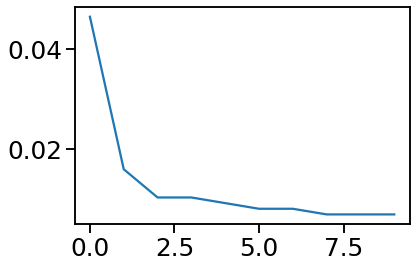

In [125]:
# empty matrix for probability vs word in topic (doing for n = 1 topic only)
n_topic_words_single_topic_analysis = 10
topic_word_probs = np.zeros((2,2,n_topic_words_single_topic_analysis))


lda_topic_word_probs = np.zeros((10,1))

# set default to nan in case any probs eval to 0..
lda_topic_word_probs[:] = np.nan

for topic in lda_topics:

    # get the list of topic words and probs
    topic_words = topic[1]

    # loop through these words and get the associated probabilities
    for ind, topic_word in enumerate(topic_words):

        lda_topic_word_probs[ind] = topic_word[1]

print(lda_topic_word_probs)
plt.plot(lda_topic_word_probs)

In [134]:
# calculate and store perplexity
perplexity_scores = np.zeros((n_bootstrap_samples,n_articles_per_sample, num_lda_topics))
perplexity = lda.log_perplexity(bow_corpus)
perplexity_scores[0,0,0] = perplexity

# calculate and store coherence
coherence_scores = np.zeros((n_bootstrap_samples,n_articles_per_sample, num_lda_topics))
coherence_model_lda = CoherenceModel(model=lda, texts=article_processed, dictionary=processed_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_scores[0,0,0] = coherence_lda

In [136]:
coherence_lda
perplexity

-5.928815914256954

-1


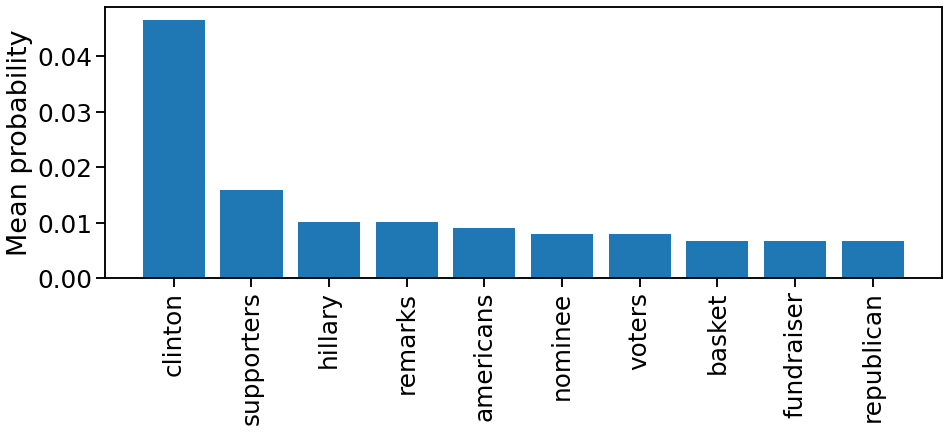

<Figure size 432x288 with 0 Axes>

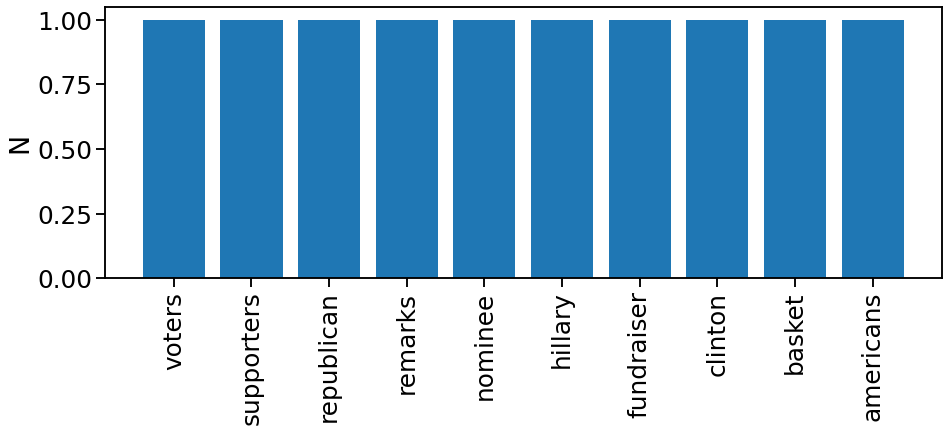

<Figure size 432x288 with 0 Axes>

In [173]:
# choose the number of LDA topics
# num_lda_topics = [1,2,3,4,5,6,7,8,9,10]
num_lda_topics = [1]

# do by sentences
do_sentences = 1

do_plot = 1

do_print = 0

n_passes = 1

unique_topic_words = 1

n_topic_words = 5

# dummy nlp variable, for now not in use because lemmatization not in use
nlp = []

# empty matrix for perplexity scores
perplexity_scores = np.zeros(( n_bootstrap_samples, n_articles_per_sample, len(num_lda_topics) ))

# empty matrix for coherence scores
coherence_scores = np.zeros(( n_bootstrap_samples, n_articles_per_sample, len(num_lda_topics) ))

# empty matrix for probability vs word in topic (doing for n = 1 topic only)
n_topic_words_single_topic_analysis = 10
topic_word_probs = np.zeros(( n_bootstrap_samples, n_articles_per_sample, n_topic_words_single_topic_analysis ))

# empty matrix for jaccard sim, set to nan in case any have 0 similarity
jaccard_sim_all = np.zeros(( n_bootstrap_samples, n_articles_per_sample, n_topic_words_single_topic_analysis ))
jaccard_sim_all[:] = np.nan



# counter for bootstrap samples
counter_nboot = -1

for i in range(n_samples):
    
    # draw random articles
#     articles_df_random_subset = all_news_df.sample(n=n_articles_per_sample)
    
    counter_nboot += 1

    counter_article = -1
    print(counter_article)
    
    for article_text in articles_df_random_subset['content']:
        
        counter_article += 1
        
        for ind_num_topics, num_topic in enumerate(num_lda_topics):

            if do_print:
                print(article_text)

            # for counting word frequencies
            article_processed_whole = process_all_articles([article_text],nlp)

            article_processed_whole = remove_stopwords(article_processed_whole,stop_words)


            if do_sentences:

                # break article into sentences
                article_text = tokenize.sent_tokenize(article_text)

                # process article
                article_processed = process_all_articles(article_text,nlp)

                # remove stopwords
                article_processed = remove_stopwords(article_processed,stop_words)

            else:

                # process article
                article_processed = process_all_articles([article_text],nlp)

                # remove stopwords
                article_processed = remove_stopwords(article_processed,stop_words)


            # get corpus, dictionary, bag of words
            processed_corpus, processed_dictionary, bow_corpus = get_simple_corpus_dictionary_bow(article_processed)

            # generate the LDA model
            lda = LdaModel(corpus = bow_corpus,
                             num_topics = num_topic,
                             id2word = processed_dictionary,
                             passes = n_passes)
            
            # calculate and store perplexity
            perplexity = lda.log_perplexity(bow_corpus)
            perplexity_scores[counter_nboot,counter_article,ind_num_topics] = perplexity

            # calculate and store coherence
            coherence_model_lda = CoherenceModel(model=lda, texts=article_processed, dictionary=processed_dictionary, coherence='c_v')
            coherence_lda = coherence_model_lda.get_coherence()
            coherence_scores[counter_nboot,counter_article,ind_num_topics] = coherence_lda
            
            # get the topics from the lda model
            lda_topics = lda.show_topics(formatted=False)

            
            # if one topic, just take top word in each generated topic
            # else, if unique_topic_words, get top word in each topic that is unique,
            #       else, just get top word in each topic even if it isn't unique

            # get top words per topic

            #  # string is for final search string
            lda_top_topic_words_string = ''

            # list is for checking previous words
            lda_top_topic_words_list = []


            # if generating more than 1 topic
            if num_topic > 1:

                # if you're okay with topic words repeating (often happens..)
                if not unique_topic_words:

                    for topic in lda_topics:

                        # get the list of topics
                        topic_words = topic[1]

                        lda_top_topic_words_string += ' '+topic_words[0][0]
                        
                        lda_top_topic_words_list.append(topic_words[0][0])

                # don't reuse a word if it has already been used
                else:

                    # loop through each list of generated topics
                    for topic in lda_topics:

                        # set word added to 0
                        word_added = 0

                        # get the list of topics
                        topic_words = topic[1]

                        # loop through words in topic
                        # add as search term only if they aren't already search terms
                        for i in range(len(topic_words)):

                            # if the current word in topic is not in list of search terms
                            if topic_words[i][0] not in lda_top_topic_words_list:

                                # add this word to list of topic/search terms
                                lda_top_topic_words_list.append(topic_words[i][0])

                                # also update the string for the search terms
                                lda_top_topic_words_string += ' '+topic_words[i][0]

                                # update word added
                                word_added = 1
                                break

                        # if no word was added because all supporting words in topic are already
                        # search terms, then just add the highest prob/first word in topic
                        if word_added == 0:
                            # if every word in this topic is already a search term,
                            # just add the first most probable word and leave the while loop
                            lda_top_topic_words_list.append(topic_words[0][0])
                            lda_top_topic_words_string += ' '+topic_words[0][0]

            else:

                for topic in lda_topics:

                    # get the list of topic words
                    topic_words = topic[1]

                    # loop through these words and get the top n number
                    counter = -1
                    for topic_word in topic_words:

                        counter += 1

                        if counter < n_topic_words:

                            lda_top_topic_words_string += ' '+topic_word[0]
                            lda_top_topic_words_list.append(topic_word[0])

            # for case of only one topic, store matrix of word probs
            if num_topic == 1:

                # generate empty vector for probs associated with words in topic
                lda_topic_word_probs = np.zeros((10,1))

                # set default to nan in case any probs eval to 0..
                lda_topic_word_probs[:] = np.nan

                for topic in lda_topics:

                    # get the list of topic words and probs
                    topic_words = topic[1]

                    # loop through these words and get the associated probabilities
                    for ind, topic_word in enumerate(topic_words):

                        # add probability to prob vector
                        lda_topic_word_probs[ind] = topic_word[1]
                        
                # add to matrix of word probs
                topic_word_probs[counter_nboot,counter_article,:] = lda_topic_word_probs[:,0]


            # count word frequencies
            word_dict_count, word_counts_top, most_common_words_list, most_common_words_string = count_word_frequencies(article_processed_whole,n_topic_words)

            # get jaccard similarity
            jaccard_sim = get_jaccard_sim(lda_top_topic_words_list, most_common_words_list)
            jaccard_sim_all[counter_nboot,counter_article,ind_num_topics] = jaccard_sim
            
            
            # add cosine similarity
            
            # add n words from counting top most frequent
            
            
            if do_plot:
                plt.figure(figsize=(15,5));
                plt.bar(topics_means,means_sorted,yerr=std_sorted);
                plt.ylabel('Mean probability');
                sns.set_context('talk', font_scale=1.5);
                plt.xticks(rotation=90);
                plt.show();
                plt.clf();
    #             plt.savefig('./eda_figs/mean_prob_vs_topic_big_ten_resumes.png', dpi=300, bbox_inches='tight')

                plt.figure(figsize=(15,5));
                plt.bar(topics_freq,freq_sorted);
                plt.ylabel('N');
                # plt.xlabel('Topics')
                sns.set_context('talk', font_scale=1.5);
                plt.xticks(rotation=90);
                plt.show();
                plt.clf();
    #             plt.savefig('./edafigs/frequency_vs_topic_big_ten_resumes.pdf')

            if do_print:
                print(topics)
                print(topics_probs_dict)
                print(' ')

                for lda_topic in lda_topics:
                    print(lda_topic)

                print(lda_top_topic_words)

            




In [148]:
lda_topic_word_probs

array([[0.04653657],
       [0.01589036],
       [0.01021559],
       [0.01021537],
       [0.00908045],
       [0.00794533],
       [0.00794528],
       [0.00681033],
       [0.00681031],
       [0.00681031]])

In [174]:

        
print(article_text)
print('most common words:',most_common_words_string)
print('word counts for most most common words:',word_counts_top)
print('lda top topic words:',lda_top_topic_words)
        

[' Hillary Clinton’s claim at a fundraiser that half of Donald Trump’s supporters fit into a “basket of deplorables” prompted a swift and negative reaction Saturday from Republicans, including denunciations and calls for her to apologize.', 'The comments echoed an accusation that Clinton had levied previously — that Trump appeals to and amplifies racist, xenophobic and anti-Semitic viewpoints.', 'But Clinton triggered a fresh controversy by claiming that “half” of Trump’s supporters fit that description.', 'At a key moment in the campaign, when both candidates are trying to sharpen their focus for the final, post-Labor Day sprint, Clinton’s remarks took attention from Trump’s spate of gaffes last week and also from her own effort to turn the public’s attention to her qualifications for office and vision for the nation.', '“You know, to just be grossly generalistic, you could put half of Trump’s supporters into what I call the ‘basket of deplorables.’ Right?” Clinton said to applause an

In [175]:
print(most_common_words_list)
print(lda_top_topic_words_list)

['hillary', 'clinton', 'supporters', 'remarks', 'nominee', 'americans', 'voters']
['clinton', 'supporters', 'hillary', 'remarks', 'americans']


In [189]:
get_jaccard_sim(lda_top_topic_words_list, most_common_words_list)

0.7142857142857143

In [182]:
vec_most_common_words = processed_dictionary.doc2bow(most_common_words_list)

vec_lda_top_topic_words = processed_dictionary.doc2bow(lda_top_topic_words_list)
vec_lda_top_topic_words.append((59,0))
vec_lda_top_topic_words.append((151,0))

In [187]:
print(lda_top_topic_words_string.split())
print(lda_top_topic_words_list)

['clinton', 'supporters', 'hillary', 'remarks', 'americans']
['clinton', 'supporters', 'hillary', 'remarks', 'americans']


In [183]:
print(vec_most_common_words)
print(vec_lda_top_topic_words)
print(word_counts_top)

[(3, 1), (8, 1), (13, 1), (34, 1), (59, 1), (66, 1), (151, 1)]
[(3, 1), (8, 1), (13, 1), (34, 1), (66, 1), (59, 0), (151, 0)]
[40, 13, 8, 7, 6]


In [191]:
cs_test = (1*1 + 1*1 + 1*1 + 1*1 + 1*1 + 1*0 + 1*0)/(np.sqrt(7)*np.sqrt(5))
print(cs_test)

0.8451542547285165


In [184]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(vec_most_common_words,vec_lda_top_topic_words)

array([[1.        , 0.98058068, 0.9701425 , 0.95757003, 0.9533652 ,
        0.9486833 , 0.9486833 ],
       [0.98058068, 1.        , 0.99886814, 0.99549547, 0.9940431 ,
        0.99227788, 0.99227788],
       [0.9701425 , 0.99886814, 1.        , 0.99887832, 0.99810199,
        0.99705449, 0.99705449],
       [0.95757003, 0.99549547, 0.99887832, 1.        , 0.99989843,
        0.99956775, 0.99956775],
       [0.95390608, 0.99423736, 0.99821106, 0.99992243, 0.99999839,
        0.99985639, 0.99985639],
       [0.9533652 , 0.9940431 , 0.99810199, 0.99989843, 1.        ,
        0.99988524, 0.99988524],
       [0.95075667, 0.99307752, 0.99754053, 0.99974053, 0.99996364,
        0.99997807, 0.99997807]])

In [94]:
lda_topics

[(0,
  [('americans', 0.019133562),
   ('clinton', 0.018184768),
   ('republican', 0.017437408),
   ('voters', 0.017211813),
   ('nominee', 0.014980899),
   ('romney', 0.014883221),
   ('supporters', 0.013291161),
   ('compared', 0.012091164),
   ('candidate', 0.011424902),
   ('disdain', 0.0114215)]),
 (1,
  [('clinton', 0.049737256),
   ('remarks', 0.019014427),
   ('movement', 0.01757419),
   ('hillary', 0.0143344095),
   ('nominee', 0.007829909),
   ('racist', 0.007826811),
   ('democratic', 0.007820644),
   ('republican', 0.007813025),
   ('sept', 0.007812294),
   ('xenophobic', 0.007810709)]),
 (2,
  [('clinton', 0.05405272),
   ('supporters', 0.039515235),
   ('fundraiser', 0.016904987),
   ('hillary', 0.01688976),
   ('pence', 0.015262421),
   ('basket', 0.014628731),
   ('remarks', 0.013507772),
   ('deplorables', 0.012188577),
   ('nominee', 0.0120312),
   ('cycle', 0.009877269)]),
 (3,
  [('clinton', 0.033918303),
   ('supporters', 0.010771941),
   ('movement', 0.009299397),

In [62]:
print(np.mean(perplexity_scores))
print(np.std(perplexity_scores))

-5.030706422886377
0.5369624187023373


In [94]:
# lda_top_topic_words
all_sides_domains

0         abcnews.go.com
1          aljazeera.com
2             apnews.com
3                bbc.com
4          bloomberg.com
5          breitbart.com
6       buzzfeednews.com
7                cbn.com
8            cbsnews.com
9          csmonitor.com
10               cnn.com
11     thedailybeast.com
12      democracynow.org
13         factcheck.org
14            forbes.com
15           foxnews.com
16          huffpost.com
17       motherjones.com
18             msnbc.com
19    nationalreview.com
20           nbcnews.com
21            nypost.com
22           nytimes.com
23           newsmax.com
24               npr.org
25          politico.com
26            reason.com
27           reuters.com
28             salon.com
29         spectator.org
30       theatlantic.com
31       theguardian.com
32           thehill.com
33               wsj.com
Name: domain, dtype: object

In [39]:
# load domain names from all sides media csv, write string for google search
all_sides_with_domains = pd.read_csv('./all_sides_media_data/allsides_final_plus_others_with_domains.csv')

all_sides_names = all_sides_with_domains['name']
all_sides_domains = all_sides_with_domains['domain']

all_sides_names_domains = pd.concat([all_sides_names,all_sides_domains],axis=1)

In [161]:
all_sides_names_domains

,name,domain,google_query
0,ABC News (Online),abcnews.go.com,site:nytimes.com dow trading rates vaccine wsj
1,Al Jazeera,aljazeera.com,site:bloomberg.com dow trading rates vaccine wsj
2,Associated Press,apnews.com,site:reuters.com dow trading rates vaccine wsj
3,BBC News,bbc.com,site:wsj.com dow trading rates vaccine wsj
4,Bloomberg,bloomberg.com,NaN
5,Breitbart News,breitbart.com,NaN
6,BuzzFeed News,buzzfeednews.com,NaN
7,CBN,cbn.com,NaN
8,CBS News,cbsnews.com,NaN
9,Christian Science Monitor,csmonitor.com,NaN
